# GPT-2 Fine-Tuning Tutorial with PyTorch & Huggingface in Colab




This is a simplified script for fine-tuning GPT2 using Hugging Face's [Transformers library](https://huggingface.co/transformers/) and PyTorch.

You should understand the basics of PyTorch and how a training loop works before getting started. [This official PyTorch tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html) serves as an excellent introduction. Familiarity with the workings of GPT2 might be useful but isn't required. The code has been written for clarity and not re-use. I'd advise refactoring it for actual projects. I've liberally taken bits from [Chris McCormick's BERT fine-tuning tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/), [Ian Porter's GPT2 tutorial](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html) and the [Hugging Face Language model fine-tuning script](https://huggingface.co/transformers/v2.0.0/examples.html#language-model-fine-tuning) so full credit to them. Chris' code has pretty much provided the basis for this script - you should definitely check out his [blog](https://mccormickml.com/tutorials/).

I should mention what the script doesn't cover:

- Using the [nlp](https://huggingface.co/nlp/) library to load in the dataset and setting up the training workflow, which looks to streamline things rather nicely.
- [Accumulated gradients](https://medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255) - this gives larger effective batch sizes than Colab allows (GPT2 is a large model, and anything more than a batch size of 2 would be enough to get a CUDA out of memory error on Colab).
- [Freezing layers](https://github.com/huggingface/transformers/issues/1431). This is the process of only changing the parameters in selected layers, made famous by the [ULMFit](https://arxiv.org/abs/1801.06146) process.
- [Using 'past'](https://huggingface.co/transformers/quickstart.html#using-the-past) when generating text. This takes in the previous state when generating successive items of text. I didn't need it.
- [Tensor packing](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html). This is a neat way of fitting in as much training data in each batch. 
- [Hyperparameter search](https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10). I settled quickly on values that seemed to produce decent values, without checking if they were optimal.

# Setup

In [1]:
!pip install transformers

In [2]:
import os
import time
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
!nvidia-smi

Fri Mar 24 06:00:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000        Off  | 00000000:00:05.0 Off |                  Off |
| 26%   25C    P8     6W / 180W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Create Training Set

The data used to finetune the language model is a set of around 1000 DJ biographies, with the aim of generating them in the same general format and style.

This data isn't public so if you want to use this script, you'll have to source your own training set.

In [4]:
# mount my Google Drive directory and access the training data located there
# gdrive_dir = '/content/gdrive/'
# data_dir = os.path.join(gdrive_dir, "'My Drive'","'Colab Notebooks'","nlp","'text gen demos'")
# filename = 'ra_top_1000_full.csv'

# drive.mount(gdrive_dir, force_remount=True)


In [5]:
# copy the data to the current Colab working directory
# !cp $data_dir/$filename .

In [6]:
dataset = [
    {
        "bio_main": "When it funks, it funks hard.\n\nBreaking Beats Since 1988.Where do you start with A Guy Called Gerald? A hidden gem, the gateway between Chicago house / Detroit Techno and the UK dance music explosion in the late 80s. He is one of a few special producers who entered dance music in the jacking zone. He is the first UK acid house producer and probably the first producer to have two instrumental dance tracks in the UK charts at the same. He formed 808 State with a drum machine, a 303, 2 Roland SH101s and 2 other humans. His collaborations stem from Frankie Knuckles, Goldie, Finley Quaye and Derrick May through to Herbie Hancock, remixed for David Bowie, Lamb, Stone Roses, Black Uhuru, Can, Tricky, Roman Fluegel and The Orb and toured with New Order, Tricky and Bebel Gilberto.\n\nWhen the history of postmodern dance music is written he is ubiquitous: his visions, his stylistic versatility and open mindedness had a huge influence on the development of global dance culture. Very early on, he experimented with acid house and helped pioneer the style that was later called jungle and drum'n'bass. Fiercely independent he's preparing himself for a string of new releases, the launch of his online shop and touring worldwide. \n\nThe Manchester scene in the late 80s radiated from the Hacienda. It was a place which grew to be a breeding ground for the likes of Laurent Garnier and Chemical Brothers and in the Summer of Love the Hacienda had a theme tune called Voodoo Ray. It was A Guy Called Gerald's first release in 1988 and became a seminal classic that put British house music firmly on the map. As part of 808 State’s first incarnation he co-produced another Hacienda classic, Pacific State. He soon decided to concentrate on his solo project and toured worldwide (and with a quarter of a ton of equipment!) performing live. \n\nIn the early 90s he launched his own label Juice Box and released a series of 12\"s that were the blueprint to what would become jungle. In 1992 he compiled these releases into the proto jungle classic \"28 Gun Bad Boy\" album. In 1995 he followed up with the definitive \"Black Secret Technology\" to critical acclaim. Black Secret Technology featured Finley's Rainbow with vocals by Finley Quaye and a collaboration with Goldie. Finley's Rainbow featured Finley Quaye who later re-released the tune on his debut album. In 2005 Knowledge Magazine ranked \"28 Gun Bad Boy\" EP was as the No. 1 jungle single of all time. His sound was an inspiration to many - Goldie, LTJ Bukem and DJ Krust have all stated his influence.\n\nBut never wanting to be stereotyped into any particular style of music his sound continued to develop. In 2000 he signed with !K7 Records and released \"Essence\" with guest vocals from singer/songwriter Wendy Page, Lady Kier and Finley Quaye. In 2005 the down tempo \"To All Things What They Need\". In 2005 he launched his Sugoi and Protechson labels. His latest album \"Proto Acid / The Berlin Sessions\", released on Berlin's Laboratory Instinct, is an infectious 71 minute continuous mix recorded live.\n\n2008 marks 20 years of A Guy Called Gerald in dance music and to celebrate a definitive collection of A Guy Called Gerald’s back catalogue is planned for release featuring rare and unreleased tracks and remixes. In July a remaster of 1995’s jungle classic “Black Secret Technology” was reissued. And in August “In Ya Head feat. Mia” came out on Berlin’s favourite Perlon Records. \n\nHe continues to tour bringing his studio into the clubs worldwide playing anywhere from 2 to now legendary 14 hour LIVE sets – no DJ software, no gimmicks, just raw, pure, undiluted AGCG riddums strictly for the dancefloor."
    }, 
    {
        "bio_main": "Purposively ricocheting between the techno world and experimental electronic music, Linell forges a distinct passage that gathers the aesthetically uncompromising motifs and missions from across this spectrum.\"The cohesive array of depth charged devices that Anthony Linell has produced is formidable. From his opening statements as Abdulla Rashim on his early label of the same name, right through to his recent work that puts his aliases aside, there is a robust and rigorous intent that compounds the elemental strategies of techno's models to apprehend his singular vision.\n\nPresiding over Stockholm's Northern Electronics label with Varg (Jonas Rönnberg), Linell dispenses with mechanisms of attention on all fronts. Marked by an indefatigable self-reliance, the label presents exactly what it means to display, and no more. Carving an idiosyncratic platform for his music is as great of a warning as there could be that Linell's leveraging little toward the benefit of the audience. By his measure, the familiarity and comfort of contemporary techno is stripped back to its rushing heart, the senses left tailgating the strobe in a fit of intuition over decision. The greater this is exposed the colder it gets, and its in these extremes that Linell's caustic rhythmic precision hits. Live, it comes off as a galvanizing strike from the outside; analysing the room as a DJ, it's a case of being pursued through the dark. \n\nJust as the brevity of Linell's output in the eyes of techno is exalted as it is brought into focus, the background to this blurs as you start to decipher his other projects. Lundin Oil skirts the fringes of noise and experimental music, and in collaboration with Varg as Ulwhedar, this is perhaps even more pronounced.\n\nPurposively ricocheting between the techno world and experimental electronic music, Linell forges a distinct passage that gathers the aesthetically uncompromising motifs and missions from across this spectrum. It's this combination and resolve that's brought Linell to the world's attention, however little that attention has been solicited."
    }, 
    {
        "bio_main": "Acid Arab is a duet from Paris whose goal is to mix all kind of Eastern music (North Africa, Lebanon, Egypt, Turkey or… Mumbai) with electronic sounds, from pioneering acid house to today’s powerful techno.Guido Minisky and Hervé Carvalho (+ Sex Schön in the studio), both djs for many years and residents of infamous Parisian club Chez Moune, have fallen in love with this music after a trip to Tunisia with Dj Gilb’R. They’ve managed to convince a lot of producers to come along with them on this fantastic voyage and create a track for their ‘Acid Arab Collections‘, which are naturally released by Gilb’R’s label, Versatile Records.\n\n\nOn this first EP you will hear the French dance master I:Cube giving his own definition of an Arabic acid track. Inspired by some old guys talking in an Algerian café, he called it “Le bon vieux temps” (‘Good old days’). The Syrian star Omar Souleyman has accepted to let Crackboy (from Tigersushi and I’m A Cliché) remix one of his famous hits ‘Shift Al Mani‘. It’s acid at its best, empowered by Souleyman’s vocals. Acid Arab organized a live session at Versatile studio with keyboardist / guitarist Turzi (Record Makers), keyboardist / bassist Judah Warsky (Pan European Recordings) and a very special guest : Adnan Mohamed, aged 60, who’s played traditional oud guitar all his life in Kurdistan and France. Dj Gilb’R, the brain behind the muscles, has mixed these sounds to create an epic cosmic symphony that the team called ‘Cosmique Arabe‘ by Boyz In The Oud. Lastly, Acid Arab themselves deliver their ‘Theme‘, a journey through beats and a Persian melody that has already got support from Gilles Peterson, Lovefingers, TLR, Skudge, Tim Sweeney and Radio Nova (Paris).\n“We are fascinated by eastern music and its codes, such as complex rhythmic structures (binary and ternary superimposing upon each other), which drive dancers to trance just like acid house does. We’d like to take these codes and use analog techno devices (beatboxes, bassline machines) to create something new : an oriental acid music which combines the coldness of techno and the emotional and dramatic power of the East. Our knowledge of the dancefloor is now digested and we have spent night after night digging records and files to know more about arabic music. We don’t want to be standardbearers of mixing whatever, we just want to be of our days. talking about mixing means there’s a split, a binary vision of an occidental vs oriental world – this is has-been. We don’t paste oriental sounds on occidental beats, we want to embody both cultures without pretending to reinvent oriental music or fooling ourselves by believing we’re inventing eastern dance music. We just want to be part of it, and contribute to this brilliant and enormous masterpiece that this music is, and has been for thousands of years.” Acid Arab aka Guido Minisky and Hervé Carvalho."
    }

]

In [7]:
# load into a data frame
df = pd.read_csv('data/nlpia_lines.csv')
print(df)

       Unnamed: 0                                          line_text  \
0               0  = Natural Language Processing in Action, Secon...   
1               1                                        :chapter: 1   
2               2                                           :part: 1   
3               3                                         :sectnums:   
4               4                                      :imagesdir: .   
...           ...                                                ...   
14373       14373  * Efficiently modeling natural language charac...   
14374       14374  * Weights in an RNN are adjusted in aggregate ...   
14375       14375  * You can use different methods to examine the...   
14376       14376  * You can model the natural language sequence ...   
14377       14377                                                NaN   

       line_number                                           filename  \
0                0  Chapter-01_Machines-that-can-read-and-writ

In [8]:
df.dropna(inplace=True) #remove NA values
df = df[df['is_text']]
bios = df.line_text.copy() 
bios

14                                     This chapter covers
16                           * The power of human language
17       * How natural language processing (NLP) is cha...
18       * The kinds of NLP tasks that machines can now...
19       * Why unleashing the NLP genie is profitable ....
                               ...                        
14372    * Because RNNs are particularly deep neural ne...
14373    * Efficiently modeling natural language charac...
14374    * Weights in an RNN are adjusted in aggregate ...
14375    * You can use different methods to examine the...
14376    * You can model the natural language sequence ...
Name: line_text, Length: 6258, dtype: object

We need to get an idea of how long our training documents are.

I'm not going to use the same tokenizer as the GPT2 one, which is a [byte pair encoding tokenizer](https://blog.floydhub.com/tokenization-nlp/). Instead, I'm using a simple one just to get a rough understanding.

/tmp/ipykernel_32/3284538386.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)


<AxesSubplot: ylabel='Density'>

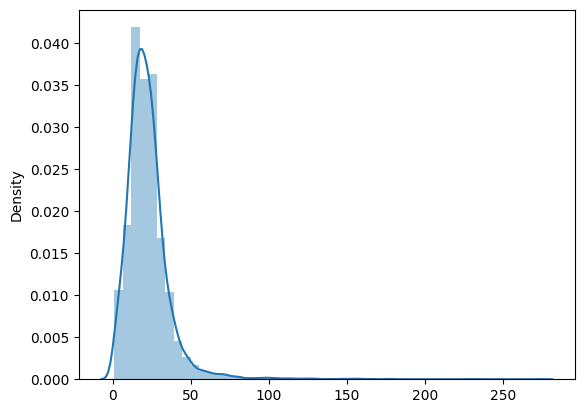

In [9]:
doc_lengths = []

for bio in bios:

    # get rough token count distribution
    tokens = nltk.word_tokenize(bio)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [10]:
# the max token length   
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.0

In [11]:
np.average(doc_lengths)

22.617929050814958

Even though these token counts won't match up to the BPE tokenizer's, I'm confident that most bios will be fit under the 768 embedding size limit for the small GPT2 model.

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens. 

In [12]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [13]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [14]:
batch_size = 5

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [15]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each bio in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the bio is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens. 

If the bio is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [16]:
dataset = GPT2Dataset(bios, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

5,632 training samples
  626 validation samples


In [17]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [18]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [19]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [20]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [22]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [23]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,127. Loss: 0.1470995843410492.   Elapsed: 0:01:40.
0:  bipartisan you, that you're a lot more successful than we were in the previous year.
, that you've the most people who have the most people, a lot of people are a lot less complicated than we are in the previous year.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,127. Loss: 0.2797248661518097.   Elapsed: 0:03:22.
0:  increasingWith all inputs in the list of inputs (including the inputs) you have done a good job on your application.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,127. Loss: 0.11012861877679825.   Elapsed: 0:05:05.
0: daySo, let's examine the question, as well as what does this "underlying question" need to do with the term "underlying," and what does it do for all three characters in the words "underlying" and "underlying" (where there are no words)?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,127. Loss: 0.12081682682037354.   Elapsed: 0:06:48.
0:  HangThis is a good bet for keeping track of the wordings of words and the meaning of them, so you can search for words that make sense to you and not just those things we mentioned in the previous chapter.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,127. Loss: 0.1238294467329979.   Elapsed: 0:08:30.
0:  foodsThey'll help make your Word2Vec vocabulary even more versatile and versatile with a slightly more compact vocabulary.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,127. Loss: 0.11063492298126221.   Elapsed: 0:10:12.
0:  trailOr if you want to keep track of the number of documents you would need to build an unsupervised network based on the NLP model trained on your dataset, you can use this model to train your neural network:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,127. Loss: 0.10929149389266968.   Elapsed: 0:11:55.
0: intendIt just looks like the "word" in your words or text.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,127. Loss: 0.11703460663557053.   Elapsed: 0:13:37.
0:  surround* The real magic is in building one or two "hot places" so you don't accidentally blow away the front.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,127. Loss: 0.10031958669424057.   Elapsed: 0:15:20.
0:  reflexAnd all those words are exactly where you want it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,127. Loss: 0.11619077622890472.   Elapsed: 0:17:02.
0:  displayAnd they would help us recognize patterns in our data - such as meaning or context rather than text or documents.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,127. Loss: 0.10318755358457565.   Elapsed: 0:18:44.
0:  pastorTo save you time and improve your NLP pipelines.

  Average training loss: 0.19
  Training epoch took: 0:19:11

Running Validation...
  Validation Loss: 0.12
  Validation took: 0:00:44

======== Epoch 2 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,127. Loss: 0.07727202773094177.   Elapsed: 0:01:42.
0:  illicitThe LSA function on the GPU keeps a record of the counts at the beginning and end of the input and outputs.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,127. Loss: 0.1286669671535492.   Elapsed: 0:03:25.
0:  LiberationThe term `kotopekaladenize` was originally used as a synonym for `kotopekaladenize` which refers to the combination of two approaches, one based on a single set of vectors, and the other based on a cluster of individual tokens or clusters of words.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,127. Loss: 0.10640221834182739.   Elapsed: 0:05:08.
0:  NamFor some NLP problems, stemming, lemmatization, stemming matrices, lemmatization matrices can also be useful.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,127. Loss: 0.12460142374038696.   Elapsed: 0:06:50.
0: IONA few researchers now use word embeddings to classify and label word usage based on their usage, and to help their users survive overzealous search engines.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,127. Loss: 0.09105958789587021.   Elapsed: 0:08:33.
0:  glimpseA vector holds a single input to the brain, it is a one-hot encoded short term memory.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,127. Loss: 0.13372330367565155.   Elapsed: 0:10:15.
0:  LaureThat is why you'll have to do a lot of tedious work to train a fully-connected neural network.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,127. Loss: 0.11979687958955765.   Elapsed: 0:11:58.
0: ismThe model may also have a "fittest" score (fittest score: 1 in this dataset) that tells the machine what the most interesting (best) combination of words is in it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,127. Loss: 0.1237281858921051.   Elapsed: 0:13:40.
0: ounIt allows us to use a small set of words to compose a word whose meaning can be determined by our brains, in our everyday lives.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,127. Loss: 0.16784775257110596.   Elapsed: 0:15:23.
0:  electionThe `TruncatedSVD` implementation (`TruncatedSVD` or `DistributedSVD`) can be used to identify the presence or absence of the presence or absence of a particular _semantic similarity_ (semantic frequency).


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,127. Loss: 0.06738443672657013.   Elapsed: 0:17:06.
0:  crazyWe don't have to tell you what they are like to have a cup of coffee in an open ocean.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,127. Loss: 0.13038012385368347.   Elapsed: 0:18:48.
0:  benchImagine trying to answer questions in English and then get the answer to a question in Arabic.

  Average training loss: 0.10
  Training epoch took: 0:19:15

Running Validation...
  Validation Loss: 0.12
  Validation took: 0:00:44

======== Epoch 3 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,127. Loss: 0.09180610626935959.   Elapsed: 0:01:42.
0:  incorporatedIn the previous sections, you had to explain the math that your neural network needs to perform all the "squishing" on the statistics to get you down on this high score.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,127. Loss: 0.1113949716091156.   Elapsed: 0:03:25.
0: PeterImagine we were trying to tell our bot what to say in our greeting intent.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,127. Loss: 0.059887468814849854.   Elapsed: 0:05:07.
0: uring* How do you process word embeddings?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,127. Loss: 0.09539409726858139.   Elapsed: 0:06:50.
0:  reproductiveSo that's what you'd like to do.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,127. Loss: 0.09729322046041489.   Elapsed: 0:08:32.
0:  zoneBut what about "better" tokens?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,127. Loss: 0.061232078820466995.   Elapsed: 0:10:14.
0:  commitsThat's why machine learning and other natural language processing is so powerful.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,127. Loss: 0.08346995711326599.   Elapsed: 0:11:57.
0:  ironyNow you can use SpaCy to extract information from text using the SpaCy logic gate (`re()`).


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,127. Loss: 0.09159547835588455.   Elapsed: 0:13:39.
0:  SahTo figure out why they are better than all the others for this single token _duckduck_duck_duck training set you need a couple of random samples and the training data.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,127. Loss: 0.0840497761964798.   Elapsed: 0:15:22.
0:  BryanYou can even use these "mini" datasets to train some regular expressions.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,127. Loss: 0.07157456129789352.   Elapsed: 0:17:04.
0:  spiritsBut for now you only need to use LDA (Linear Dirichlet Allocation) to find the single vector nearest to your topic.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,127. Loss: 0.05783459544181824.   Elapsed: 0:18:47.
0:  seesA nice little feature you could change is the order the words that appear within each sentence, because the order is determined by how far apart a pair of words are in your topic and where those words should end.

  Average training loss: 0.08
  Training epoch took: 0:19:14

Running Validation...
  Validation Loss: 0.12
  Validation took: 0:00:44

======== Epoch 4 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,127. Loss: 0.05730636417865753.   Elapsed: 0:01:43.
0:  hungryA good first chatbot will let you know the sentiment and sentiment associated with each response.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,127. Loss: 0.0734810158610344.   Elapsed: 0:03:25.
0:  PTThey also create a huge list of stopwords to stop short of explicitly labeling a word with the stem `.`.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,127. Loss: 0.0578208826482296.   Elapsed: 0:05:07.
0: üThe character for female is a combination of the characters for female.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,127. Loss: 0.06713144481182098.   Elapsed: 0:06:50.
0: ruceBut this can be a problem for languages like Ada, Bash, and C, and most importantly for web search and content-uploaded content.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,127. Loss: 0.06220017746090889.   Elapsed: 0:08:32.
0:  derivativesAn RNN needs only one neuron for each output (output) and only one kernel for each output (output).


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,127. Loss: 0.053184233605861664.   Elapsed: 0:10:15.
0: And your code is actually recycling the output from the previous model.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,127. Loss: 0.08740857988595963.   Elapsed: 0:11:57.
0:  rememberingWhen you multiply words by TF-IDF vectors, they get a sequence of words, typically one-hot encoded TF-IDF vectors for your documents.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,127. Loss: 0.09287717938423157.   Elapsed: 0:13:39.
0:  Sources* Understanding sentiment and word embeddings


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,127. Loss: 0.06111345812678337.   Elapsed: 0:15:21.
0: emsYou should have a consistent length for the padding tokens required to keep track of which words are where.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,127. Loss: 0.06452326476573944.   Elapsed: 0:17:04.
0: tzAnd the NLTK pipeline will keep you from using all the words it hasn't already seen in all the textbooks.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,127. Loss: 0.06966690719127655.   Elapsed: 0:18:46.
0: maticThis kind of artificial neural network architectures first popularized in the academic papers of Tomas Mikolov and Geoffrey Zweig.

  Average training loss: 0.07
  Training epoch took: 0:19:13

Running Validation...
  Validation Loss: 0.13
  Validation took: 0:00:44

======== Epoch 5 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,127. Loss: 0.04701196029782295.   Elapsed: 0:01:43.
0:  syndFor example, the Python `nn.Embedding` layer can embed the convolution into convolutional filters as you are processing a sequence of 2 or more convolutions within a convolutional layer.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,127. Loss: 0.05799892917275429.   Elapsed: 0:03:25.
0:  gamEach unit in your perceptron can have attributes, or weights, that control its own understanding of the world.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,127. Loss: 0.04723624512553215.   Elapsed: 0:05:07.
0:  injuryAnd it does not need to understand that you can find documents where you can use them to achieve high performance or validation.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,127. Loss: 0.0678294226527214.   Elapsed: 0:06:49.
0: azaIf you want you can disable it by modifying your kernel.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,127. Loss: 0.04556809738278389.   Elapsed: 0:08:31.
0:  membraneThis is what makes RNNs unique.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,127. Loss: 0.041550006717443466.   Elapsed: 0:10:13.
0: ijingYou could remove that "you" ending from "you" so that the stem "you" would have a place in your vocabulary for the stem "Marie Curie" without too many meaningless "you."


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,127. Loss: 0.051353972405195236.   Elapsed: 0:11:56.
0:  castThat way you don't have to store all the complicated logic required to trigger the output of a linear layer.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,127. Loss: 0.05108635872602463.   Elapsed: 0:13:38.
0:  purchIt has often been the case that your search results that use keyword search, adverb search and similar techniques can be misleading.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,127. Loss: 0.11730971932411194.   Elapsed: 0:15:21.
0:  shouldersYour machine is going to be able to see through your words (character 2-grams) and see what you are actually saying.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,127. Loss: 0.07677747309207916.   Elapsed: 0:17:03.
0:  builtSo it's kind of like building a building in reverse.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,127. Loss: 0.0687505379319191.   Elapsed: 0:18:45.
0:  openlyIn this section, you will begin to see how this blending of culture, language, and gender can affect your decisions about when to apply lemmatization to your dataset or how you will decide about tokenizing it.

  Average training loss: 0.05
  Training epoch took: 0:19:12

Running Validation...
  Validation Loss: 0.15
  Validation took: 0:00:44

Training complete!
Total training took 1:39:44 (h:mm:ss)


Let's view the summary of the training process.

In [24]:
# Display floats with two decimal places.
#pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.192283,0.121643,0:19:11,0:00:44
2,0.103684,0.119630,0:19:15,0:00:44
3,0.084480,0.123775,0:19:14,0:00:44
4,0.066680,0.132695,0:19:13,0:00:44
5,0.049526,0.147393,0:19:12,0:00:44


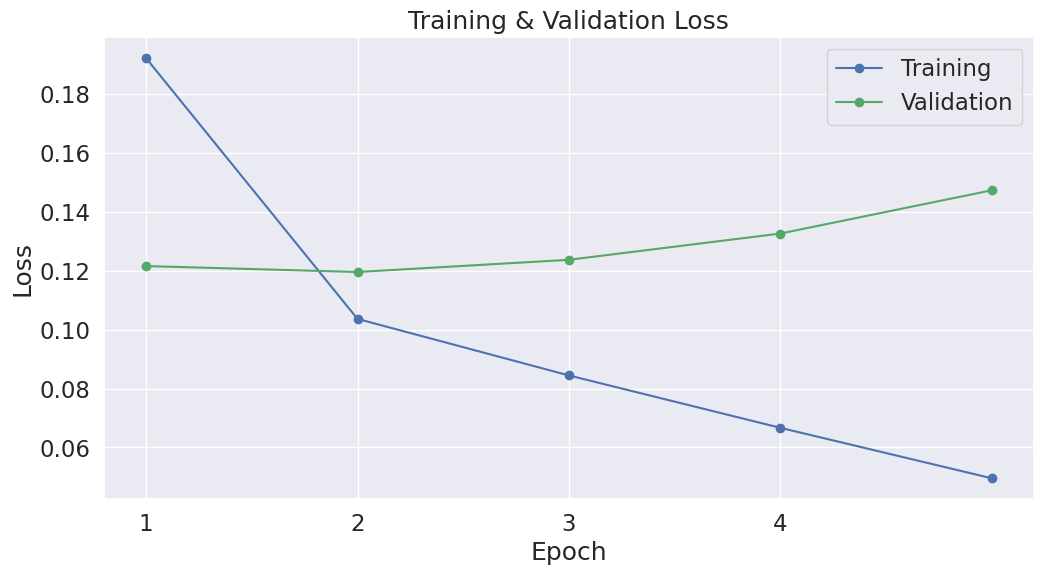

In [25]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [26]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model


In [27]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = 'model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to model_save/


('model_save/tokenizer_config.json',
 'model_save/special_tokens_map.json',
 'model_save/vocab.json',
 'model_save/merges.txt',
 'model_save/added_tokens.json')

In [28]:
!ls -l --block-size=K ./model_save/

total 499866K
-rw-r--r-- 1 root root      1K Mar 24 07:40 added_tokens.json
-rw-r--r-- 1 root root      1K Mar 24 07:40 config.json
-rw-r--r-- 1 root root    446K Mar 24 07:40 merges.txt
-rw-r--r-- 1 root root 498441K Mar 24 07:40 pytorch_model.bin
-rw-r--r-- 1 root root      1K Mar 24 07:40 special_tokens_map.json
-rw-r--r-- 1 root root      1K Mar 24 07:40 tokenizer_config.json
-rw-r--r-- 1 root root    976K Mar 24 07:40 vocab.json


In [29]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 487M Mar 24 07:40 ./model_save/pytorch_model.bin


In [30]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ $data_dir

# # Load a trained model and vocabulary that you have fine-tuned
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

cp: missing destination file operand after './model_save/'
Try 'cp --help' for more information.


# Generate Text

In [31]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
0: And it's not all that useful!


1: Let's see how your LDiA topic model performs on the output from `word2vec` training and the TF-IDF vectors produced by `word2vec` on the training corpus.


2: You would have to skim several pages to find the answer you're looking for.




These aren't bad at all!
